# Viva Streets Impact by Radius

Is there a reduction in crashes around Viva Streets on Sundays? Look for crashes in the vicinity compared to the city as a whole. 

Viva Streets closures:

* Broadway from Alameda north
* Continues up Welton
* Ends at Downing

In [1]:
import json
import pytz
import folium
from folium.features import DivIcon
from folium.plugins import HeatMap

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib._color_data import TABLEAU_COLORS

import os
os.chdir('..')

from scripts.crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

In [3]:
viva_street_masterids = [
    
    # Broadway
    5798
    , 5760
    , 6711
    , 6710
    , 6698
    , 16946
    , 17181
    , 26919
    , 16937
    , 5413
    , 5324
    , 5244
    , 6635
    , 18788
    , 18789
    , 27763
    , 5027
    , 4924
    , 4832
    , 4706
    , 4528
    , 4455
    , 4358
    , 16499
    , 25138
    , 25137
    , 25136
    , 25141
    , 25139
    , 3747
    , 25134
    , 25130
    , 26183
    , 26184
    
    # Welton
    , 24986
    , 24987
    , 24984
    , 24983
    , 24982
    , 24981
    , 24980
    , 24979
    , 24988
    , 24990
    , 24992
    , 24991
    , 24989
]

In [4]:
# Map all crashes in the bounds

query = f"""
with viva_streets as (
    select *

    from street_centerline sc

    where sc.masterid in ({','.join(str(street) for street in viva_street_masterids)})
)

, crashes_viva as (
    select c.*
    , ST_DWithin(vs.geom_denver, c.geom_denver, 5280) as in_viva_zone

    from crashes c, viva_streets vs
)

select
to_char(reported_date at time zone 'America/Denver', 'YYYY-MM-DD') as crash_date
, to_char(reported_date at time zone 'America/Denver', 'Mon FMDD') as crash_date_str
, count(*) as num_crashes
, sum(in_viva_zone::int) as num_crashes_in_viva_zone
, sum((not in_viva_zone)::int) as num_crashes_not_in_viva_zone

from crashes_viva cv

where extract(isodow from reported_date at time zone 'America/Denver') = 7
and date_part('year', reported_date) = 2023
and cv.geo_lat is not null

group by 1,2
order by 1
"""

# print(query)
sunday_crashes = pd.read_sql(query, cda.conn)
# sunday_crashes

In [5]:
assert ((
    sunday_crashes.num_crashes 
    == sunday_crashes.num_crashes_in_viva_zone + sunday_crashes.num_crashes_not_in_viva_zone
).all()), 'Sum of crashes should match total'

In [6]:
sunday_crashes['perc_in_viva_zone'] = (
    sunday_crashes.num_crashes_in_viva_zone / sunday_crashes.num_crashes
)

In [7]:
# Color the Viva days orange

data_to_plot = sunday_crashes.copy()

viva_sundays = [
    datetime(2023, 5, 14)
    , datetime(2023, 6, 4)
    , datetime(2023, 7, 9)
    , datetime(2023, 8, 6)
]

data_to_plot['crash_date'] = pd.to_datetime(data_to_plot['crash_date'])

data_to_plot['color'] = 'lightgrey'
data_to_plot.loc[data_to_plot.crash_date.isin(viva_sundays), 'color'] = TABLEAU_COLORS['tab:orange']

data_to_plot['label'] = 'Not Viva Sunday'
data_to_plot.loc[data_to_plot.crash_date.isin(viva_sundays), 'label'] = 'Viva Sunday'

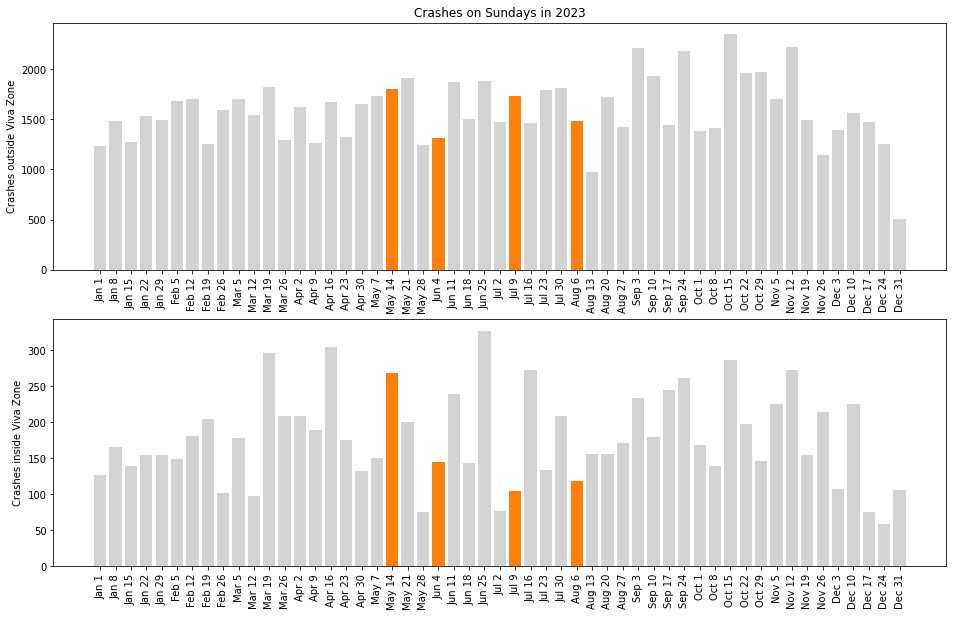

In [8]:
fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=1)

ax[0].bar(
    x=data_to_plot.crash_date_str
    , height=data_to_plot.num_crashes_not_in_viva_zone
    , color=data_to_plot.color
)

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel('Crashes outside Viva Zone')
ax[0].set_title('Crashes on Sundays in 2023')

ax[1].bar(
    x=data_to_plot.crash_date_str
    , height=data_to_plot.num_crashes_in_viva_zone
    , color=data_to_plot.color
)

ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylabel('Crashes inside Viva Zone')

_ = plt.savefig('images/viva_zone_barplot.png', transparent=False, facecolor='white', bbox_inches='tight')

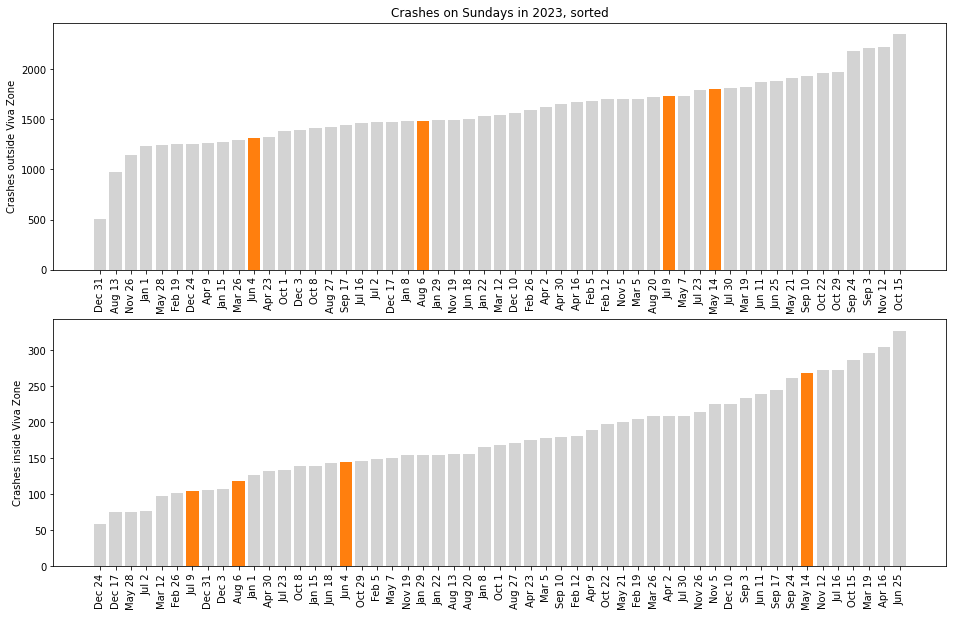

In [9]:
fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=1)

data_to_plot_sorted_outside = data_to_plot.sort_values(by='num_crashes_not_in_viva_zone')

ax[0].bar(
    x=data_to_plot_sorted_outside.crash_date_str
    , height=data_to_plot_sorted_outside.num_crashes_not_in_viva_zone
    , color=data_to_plot_sorted_outside.color
)

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel('Crashes outside Viva Zone')
ax[0].set_title('Crashes on Sundays in 2023, sorted')

data_to_plot_sorted_inside = data_to_plot.sort_values(by='num_crashes_in_viva_zone')

ax[1].bar(
    x=data_to_plot_sorted_inside.crash_date_str
    , height=data_to_plot_sorted_inside.num_crashes_in_viva_zone
    , color=data_to_plot_sorted_inside.color
)

ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylabel('Crashes inside Viva Zone')

_ = plt.savefig('images/viva_zone_barplot_sorted.png', transparent=False, facecolor='white', bbox_inches='tight')

In [10]:
data_to_plot.groupby('label').agg(
    median_crashes_inside_viva=('num_crashes_in_viva_zone', 'median')
    , median_crashes_outside_viva=('num_crashes_not_in_viva_zone', 'median')
    , num_days=('color', 'count')
)

,median_crashes_inside_viva,median_crashes_outside_viva,num_days
label,,,
Not Viva Sunday,171.0,1548.0,49
Viva Sunday,131.5,1604.0,4


In [11]:
data_to_plot[data_to_plot.label == 'Viva Sunday']

,crash_date,crash_date_str,num_crashes,num_crashes_in_viva_zone,num_crashes_not_in_viva_zone,perc_in_viva_zone,color,label
19,2023-05-14,May 14,2068,268,1800,0.129594,#ff7f0e,Viva Sunday
22,2023-06-04,Jun 4,1457,145,1312,0.099520,#ff7f0e,Viva Sunday
27,2023-07-09,Jul 9,1833,105,1728,0.057283,#ff7f0e,Viva Sunday
31,2023-08-06,Aug 6,1598,118,1480,0.073842,#ff7f0e,Viva Sunday


In [12]:
def minmax(list_of_series):
    
    return [
        min([s.min() for s in list_of_series])
        , max([s.max() for s in list_of_series])
    ]

In [13]:
minmax([
    data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_not_in_viva_zone']
    , data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_not_in_viva_zone']
])

[505, 2346]

In [14]:
minmax([
    data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_in_viva_zone']
    , data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_in_viva_zone']
])

[59, 327]

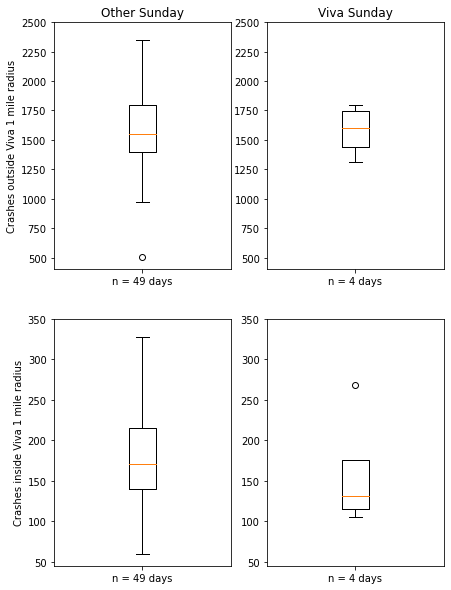

In [15]:
fig, ax = plt.subplots(figsize=(7,10), nrows=2, ncols=2)
ax[0][0].boxplot(data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_not_in_viva_zone'])
ax[0][1].boxplot(data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_not_in_viva_zone'])
ax[1][0].boxplot(data_to_plot.loc[data_to_plot.label == 'Not Viva Sunday', 'num_crashes_in_viva_zone'])
ax[1][1].boxplot(data_to_plot.loc[data_to_plot.label == 'Viva Sunday', 'num_crashes_in_viva_zone'])

row_lims = [
    [400, 2500]
    , [45, 350]
]

for i in [0,1]:
    ax[i][0].set_ylim(row_lims[i])
    ax[i][1].set_ylim(row_lims[i])

ax[0][0].set_title('Other Sunday')
ax[0][1].set_title('Viva Sunday')
ax[0][0].set_ylabel('Crashes outside Viva 1 mile radius')
ax[1][0].set_ylabel('Crashes inside Viva 1 mile radius')

ax[0][0].set_xticklabels(['n = 49 days'])
ax[0][1].set_xticklabels(['n = 4 days'])
ax[1][0].set_xticklabels(['n = 49 days'])
ax[1][1].set_xticklabels(['n = 4 days'])

_ = plt.savefig('images/viva_zone_boxplot.png', transparent=False, facecolor='white', bbox_inches='tight')

## Map the Viva street segments

In [16]:
query = f"""
select gid, masterid, st_AsGeoJSON(sc.geom) as street_line

from street_centerline sc

where sc.masterid in ({','.join(str(street) for street in viva_street_masterids)})
"""

streets_to_map = pd.read_sql(query, cda.conn)

In [17]:
this_map = folium.Map(prefer_canvas=True)

street_color = 'red'

for idx, row in streets_to_map.iterrows():
    folium.GeoJson(row.street_line, style_function=lambda x: {'color': street_color}).add_to(this_map)

    street_line_dict = json.loads(row.street_line)
    middle_point = int(np.round(len(street_line_dict['coordinates'][0]) / 2))
    
#     folium.map.Marker(
#         [street_line_dict['coordinates'][0][middle_point][1], street_line_dict['coordinates'][0][middle_point][0]]
#         , icon=DivIcon(
#             icon_size=(250,36)
#             , icon_anchor=(0,0)
#             , html=f'<div style="font-size: 20pt; color:{street_color}">masterid: {row.masterid:.0f}</div>'
#         )
#      ).add_to(this_map)

this_map.fit_bounds(this_map.get_bounds())
this_map

## Heatmaps of Viva zone on Viva Sundays versus Other Sundays